In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import json

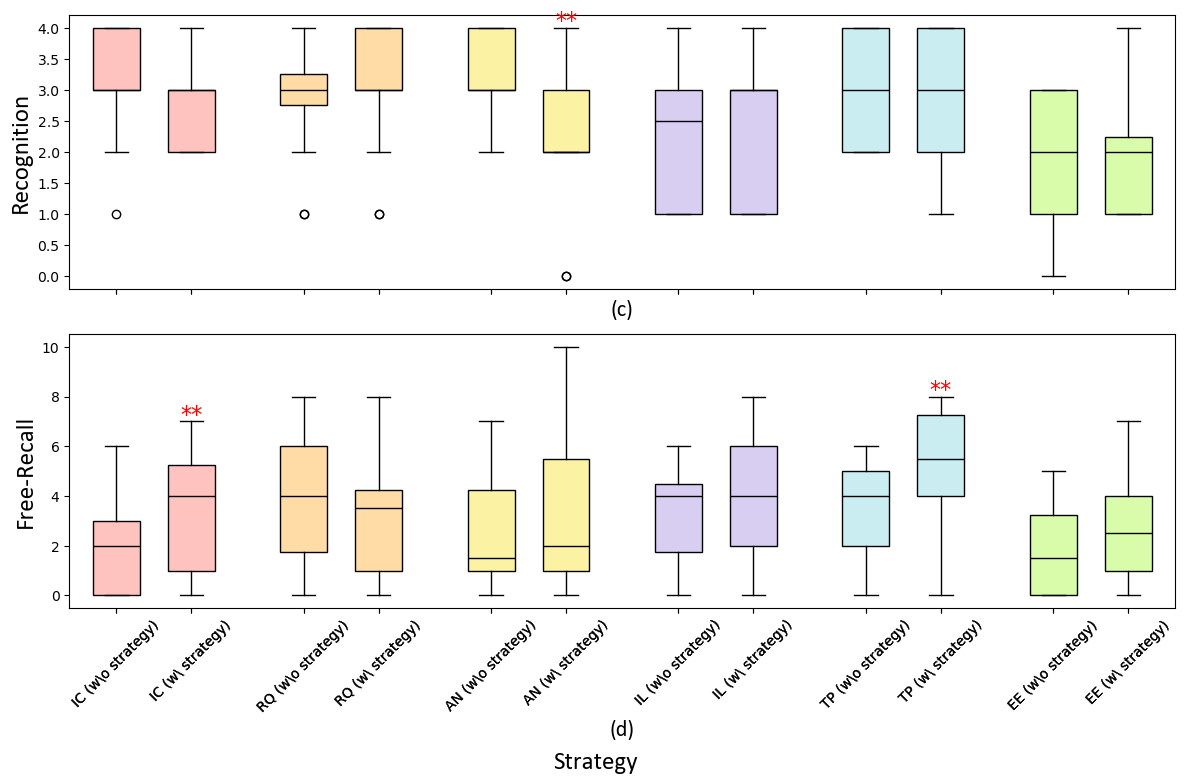

In [13]:
# Load the uploaded CSV data
file_path = 'questionnaire/long_term/response_summary_long.csv'
data = pd.read_csv(file_path)

# Define font
font = 'Calibri'

# Define the desired order of strategies
strategies = ['LC', 'RQ', 'AN', 'IL', 'TP', 'EE']

# Initialize dictionary to store Wilcoxon test results
results = {}

# Define colors for each strategy
colors = {
    'IC': '#FFC3BF',
    'RQ': '#FFDCA6',
    'AN': '#FBF2A3',
    'IL': '#D8CEF2',
    'TP': '#CAEDF2',
    'EE': '#D8FCAA'
}

# Function to create and save a plot for given columns
def create_and_save_plots(columns, file_name):
    fig, axs = plt.subplots(len(columns), 1, figsize=(12, 8), sharex=True)
    
    for i, column in enumerate(columns):
        ax = axs[i]
        combined_data = []
        labels = []
        box_colors = []
        positions = []

        for idx, strategy in enumerate(strategies):
            strategy_data = data[data['strategy'] == strategy]
            
            # Prepare data for Wilcoxon test
            method_0_data = strategy_data[strategy_data['method'] == 0][column].values
            method_1_data = strategy_data[strategy_data['method'] == 1][column].values
            
            # Perform Wilcoxon test
            wilcoxon_result = wilcoxon(method_0_data, method_1_data)
            results[column] = wilcoxon_result
            
            # Prepare data for boxplot
            combined_data.append(method_0_data)
            combined_data.append(method_1_data)
            if strategy == 'LC':
                strategy = 'IC'
            labels.append(f'{strategy} (w\\o strategy)')
            labels.append(f'{strategy} (w\\ strategy)')
            box_colors.append(colors[strategy])
            box_colors.append(colors[strategy])
            
            # Set custom positions to reduce the gap
            positions.append(idx * 2)
            positions.append(idx * 2 + 0.8)
            
            # Get p-value
            p_value = wilcoxon_result.pvalue
            
            # Determine number of asterisks
            if p_value < 0.05:
                num_asterisks = 2
            elif p_value < 0.1:
                num_asterisks = 1
            else:
                num_asterisks = 0
            
            # Add asterisks to the plot
            if num_asterisks > 0:
                y_max = max(method_1_data)
                ax.text(positions[-1], y_max, '*' * num_asterisks, color='red', ha='center', fontsize=16)

        # Plotting combined boxplot for the column
        boxplot = ax.boxplot(combined_data, labels=labels, patch_artist=True, positions=positions)
        
        # Set colors for each box
        for patch, color in zip(boxplot['boxes'], box_colors):
            patch.set_facecolor(color)
        
        # Change the median line color to black
        for median in boxplot['medians']:
            median.set_color('black')
        
        if column == 'withoutcues':
            title_word = 'Free-Recall'
        elif column == 'score':
            title_word = 'Recognition'
        elif column == 'theme':
            title_word = 'Cued Recall'
        
        if column == 'score':
            ax.set_xlabel('(c)', fontsize=16, fontname=font)
        # elif column == 'theme':
        #     ax.set_xlabel('(d)', fontsize=16, fontname=font)
        elif column == 'withoutcues':
            ax.set_xlabel('(d)', fontsize=16, fontname=font)

        ax.set_ylabel(title_word, fontsize=18, fontname=font)
        ax.tick_params(axis='x', rotation=45)

    # Set the shared x-axis label
    fig.text(0.5, 0.04, 'Strategy', ha='center', va='center', fontsize=18, fontname=font)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()
    
    # Save the plot as a PDF file
    # plt.savefig(file_name)
    # plt.close()

# Create and save plots for the specified columns
create_and_save_plots(['score', 'withoutcues'], 'figs/long_term_plots.png')